# Final Capstone Project
## Best location for an Italian restaurant among top US cities

#### by Ignacio de Juan
#### November 2020, Final Project Assignment for IBM Data Science Course

### 1. Introduction / Business Problem

We need to take the decision of where is the best location to open a new restaurant of a certain cuisine type in a top city of the USA. In this case it will be Italian cuisine.

The decision of opening a new restaurant should take into consideration the competition, demand and likelihood of success taken into account as much information available.

Through this exercise we will address the following questions:

- Which are the cities with a highest potential based on the level of concentration of these type of restaurants?
- Is the size of the local Italian descent community a variable that affects the number of Italian restaurants? 
- What other factors should we take into account for such a decision? size of the city, other cuisine competition?

With the aid of Wikipedia tables and the Foursquare API we will navigate through the data, looking for insights and arguments to help our final decision.  

Lastly, we will point out the caveats and potential further developments of this exercise.

*Target Audience*

This analysis can be of interest to entrepreneurs, investors and corporates that are considering the set-up of a new business or the expansion of their current one. The provided framework can be useful to determine where to open the restaurant and what strategy should be followed.

### 2. Data

We will take data from top US cities, ranked by population. The reason for taking the largest cities is to achieve a sufficiently large dataset to draw valid conclusions. We will be using Wikipedia to identify the target cities of our study.

Foursquare will serve as our database for the restaurant data. 

In the following sections we describe in practical terms, with examples, how is this information obtained and put in the right format to be used in the subsequent analysis phase.

#### Set up

In [1]:
import pandas as pd
from pandas import json_normalize
import numpy as np
import requests

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


%matplotlib inline
mpl.style.use(['seaborn'])

# !pip install python-dotenv

# Credentials file
%load_ext dotenv
%dotenv

import os

import json

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
#Setting up Foursquare

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value


#### Retrieving the Data 

##### US cities data

We retrieve the list of US cities with their population and other relevant data

Source: Wikipedia, https://en.m.wikipedia.org/wiki/List_of_United_States_cities_by_population

In [3]:
# Code to retrieve the cities

url = 'https://en.m.wikipedia.org/wiki/List_of_United_States_cities_by_population'
dfs = pd.read_html(url)

print(len(dfs))

print(dfs[3])

df = dfs[3]

11
     2019rank               City              State[c]  2019estimate  \
0           1   New York City[d]              New York       8336817   
1           2        Los Angeles            California       3979576   
2           3            Chicago              Illinois       2693976   
3           4         Houston[3]                 Texas       2320268   
4           5            Phoenix               Arizona       1680992   
5           6    Philadelphia[e]          Pennsylvania       1584064   
6           7        San Antonio                 Texas       1547253   
7           8          San Diego            California       1423851   
8           9             Dallas                 Texas       1343573   
9          10           San Jose            California       1021795   
10         11             Austin                 Texas        978908   
11         12    Jacksonville[f]               Florida        911507   
12         13         Fort Worth                 Texas       

Next, we will clean the city names to make them standard and usable in our queries to Foursquare API. 

In [4]:
df['City'] = df['City'].str.replace("\[.*\]","")
df.head()

,2019rank,City,State[c],2019estimate,2010Census,Change,2016 land area,2016 land area.1,2016 population density,2016 population density.1,Location
0,1,New York City,New York,8336817,8175133,+1.98%,301.5 sq mi,780.9 km2,"28,317/sq mi","10,933/km2",40°39′49″N 73°56′19″W﻿ / ﻿40.6635°N 73.9387°W
1,2,Los Angeles,California,3979576,3792621,+4.93%,468.7 sq mi,"1,213.9 km2","8,484/sq mi","3,276/km2",34°01′10″N 118°24′39″W﻿ / ﻿34.0194°N 118.4108°W
2,3,Chicago,Illinois,2693976,2695598,−0.06%,227.3 sq mi,588.7 km2,"11,900/sq mi","4,600/km2",41°50′15″N 87°40′54″W﻿ / ﻿41.8376°N 87.6818°W
3,4,Houston,Texas,2320268,2100263,+10.48%,637.5 sq mi,"1,651.1 km2","3,613/sq mi","1,395/km2",29°47′12″N 95°23′27″W﻿ / ﻿29.7866°N 95.3909°W
4,5,Phoenix,Arizona,1680992,1445632,+16.28%,517.6 sq mi,"1,340.6 km2","3,120/sq mi","1,200/km2",33°34′20″N 112°05′24″W﻿ / ﻿33.5722°N 112.0901°W


In [5]:
df = df[["City","State[c]","2019estimate"]]
df.head()

,City,State[c],2019estimate
0,New York City,New York,8336817
1,Los Angeles,California,3979576
2,Chicago,Illinois,2693976
3,Houston,Texas,2320268
4,Phoenix,Arizona,1680992


In [6]:
df.rename(columns={"State[c]":"State","2019estimate":"Population"},inplace = True)
df["Population"] = round(df["Population"]/1000000,1)
df.head()

/Users/idejuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-6-59bf041bb022>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Population"] = round(df["Population"]/1000000,1)


In [8]:
# The scope of the analysis will be the top 20 cities ranked by population
cities = list(df['City'][0:20])
print(cities)

['New York City', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose', 'Austin', 'Jacksonville', 'Fort Worth', 'Columbus', 'Charlotte', 'San Francisco', 'Indianapolis', 'Seattle', 'Denver', 'Washington']


##### Retrieving venue data from Foursquare

In [9]:
# Foursquare API credentials and endpoint
CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
VERSION = '20200616'
URL = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, 5000)

We will now load the types of cuisines available in Foursquare

In [10]:
cuisines = {
    'Afghan': '503288ae91d4c4b30a586d67', 
    'African': '4bf58dd8d48988d1c8941735', 
    'American': '4bf58dd8d48988d14e941735', 
    'Burmese': '56aa371be4b08b9a8d573568', 
    'Cambodian': '52e81612bcbc57f1066b7a03', 
    'Chinese': '4bf58dd8d48988d145941735', 
    'Filipino': '4eb1bd1c3b7b55596b4a748f', 
    'Himalayan': '52e81612bcbc57f1066b79fb', 
    'Indonesian': '4deefc054765f83613cdba6f', 
    'Japanese': '4bf58dd8d48988d111941735', 
    'Korean': '4bf58dd8d48988d113941735', 
    'Malay': '4bf58dd8d48988d156941735', 
    'Mongolian': '4eb1d5724b900d56c88a45fe', 
    'Thai': '4bf58dd8d48988d149941735', 
    'Tibetan': '52af39fb3cf9994f4e043be9', 
    'Vietnamese': '4bf58dd8d48988d14a941735', 
    'Australian': '4bf58dd8d48988d169941735', 
    'Austrian': '52e81612bcbc57f1066b7a01', 
    'Bangladeshi': '5e179ee74ae8e90006e9a746', 
    'Belgian': '52e81612bcbc57f1066b7a02', 
    'Caribbean': '4bf58dd8d48988d144941735', 
    'Caucasian': '5293a7d53cf9994f4e043a45', 
    'Czech': '52f2ae52bcbc57f1066b8b81', 
    'Dutch': '5744ccdfe4b0c0459246b4d0', 
    'Belarusian': '52e928d0bcbc57f1066b7e97', 
    'Bosnian': '58daa1558bbb0b01f18ec1ee', 
    'Bulgarian': '56aa371be4b08b9a8d5734f3', 
    'Romanian': '52960bac3cf9994f4e043ac4', 
    'Tatar': '52e928d0bcbc57f1066b7e98', 
    'English': '52e81612bcbc57f1066b7a05', 
    'French': '4bf58dd8d48988d10c941735', 
    'German': '4bf58dd8d48988d10d941735', 
    'Greek': '4bf58dd8d48988d10e941735', 
    'Hawaiian': '52e81612bcbc57f1066b79fe', 
    'Hungarian': '52e81612bcbc57f1066b79fa', 
    'Indian': '4bf58dd8d48988d10f941735', 
    'Italian': '4bf58dd8d48988d110941735', 
    'Salvadoran': '5745c7ac498e5d0483112fdb', 
    'Argentinian': '4bf58dd8d48988d107941735', 
    'Brazilian': '4bf58dd8d48988d16b941735', 
    'Colombian': '58daa1558bbb0b01f18ec1f4', 
    'Peruvian': '4eb1bfa43b7b52c0e1adc2e8', 
    'Venezuelan': '56aa371be4b08b9a8d573558', 
    'Moroccan': '4bf58dd8d48988d1c3941735', 
    'Mexican': '4bf58dd8d48988d1c1941735', 
    'Egyptian': '5bae9231bedf3950379f89e1', 
    'Iraqi': '5bae9231bedf3950379f89e7', 
    'Israeli': '56aa371be4b08b9a8d573529', 
    'Kurdish': '5744ccdfe4b0c0459246b4ca', 
    'Lebanese': '58daa1558bbb0b01f18ec1cd', 
    'Persian': '52e81612bcbc57f1066b79f7', 
    'Syrian': '5bae9231bedf3950379f89da', 
    'Yemeni': '5bae9231bedf3950379f89ea', 
    'Pakistani': '52e81612bcbc57f1066b79f8', 
    'Polish': '52e81612bcbc57f1066b7a04', 
    'Portuguese': '4def73e84765ae376e57713a', 
    'Russian': '5293a7563cf9994f4e043a44', 
    'Scandinavian': '4bf58dd8d48988d1c6941735', 
    'Scottish': '5744ccdde4b0c0459246b4a3', 
    'Slovak': '56aa371be4b08b9a8d57355a', 
    'Spanish': '4bf58dd8d48988d150941735', 
    'Sri Lankan': '5413605de4b0ae91d18581a9', 
    'Swiss': '4bf58dd8d48988d158941735', 
    'Turkish': '4f04af1f2fb6e1c99f3db0bb', 
    'Ukranian': '52e928d0bcbc57f1066b7e96'
}

We continue with the code to retrieve all the restaurants for each city and cuisine

In [11]:
# Important: In order to avoid loading the data from the Foursquare API every time the notebook is reloaded, we can download the data to a .csv file once and then reuse it. 
# Write DataFrame to CSV, use the first time you want to download the DataFrame to a CSV
#restaurants.to_csv('restaurants.csv', index=False)

read_local_file = True


if (read_local_file == True):
    restaurants_from_csv = pd.read_csv('restaurants.csv', keep_default_na=False, na_values=[""])
    restaurants = restaurants_from_csv
else:
    restaurants = pd.DataFrame(columns=['City', 'Cuisine', 'Total restaurants'])
    for city in cities:
        print(city)
        for cuisine_name, category_id in cuisines.items():
            # For each city, retrieve the top restaurants from Foursquare for each cuisine...
            query = requests.get("{url}&near={city}&categoryId={category_id}".format(url=URL, city=city, category_id=category_id))
            if query.status_code == 200:
                number = query.json()
                restaurants = restaurants.append({
                    'City': city,
                    'Cuisine': cuisine_name,
                    'Total restaurants': number['response']['totalResults']
                }, ignore_index=True)
        
restaurants

,City,Cuisine,Total restaurants
0,New York City,Afghan,13
1,New York City,African,91
2,New York City,American,376
3,New York City,Burmese,9
4,New York City,Cambodian,9
5,New York City,Chinese,350
6,New York City,Filipino,23
7,New York City,Himalayan,12
8,New York City,Indonesian,14
9,New York City,Japanese,340


In [12]:
# Let's see what cities have been properly downloaded
len(np.unique(restaurants['City']))

14

For some reason, after several attemps, Foursquare API does only respond with data for 14 cities. It looks like there is a limitation from Foursquare. Let's continue with it.    
We will calculate the total restaurants per city.

In [13]:
restaurants_total = restaurants.groupby('City').sum().reset_index()
restaurants_total.head()

,City,Total restaurants
0,Austin,1642
1,Chicago,3207
2,Columbus,981
3,Dallas,2215
4,Fort Worth,1002


In [14]:
df_cities = pd.merge(restaurants_total, df, on='City')
df_cities.sort_values('Population', ascending = False)

,City,Total restaurants,State,Population
9,New York City,5574,New York,8.3
8,Los Angeles,3888,California,4.0
1,Chicago,3207,Illinois,2.7
6,Houston,2952,Texas,2.3
11,Phoenix,1607,Arizona,1.7
10,Philadelphia,2458,Pennsylvania,1.6
12,San Antonio,1595,Texas,1.5
13,San Diego,2348,California,1.4
4,Dallas,2215,Texas,1.3
0,Austin,1642,Texas,1.0


#### Exploring the Data

We can now make some evaluation of the dataset, such as looking at the amount of restaurants against the population figures:

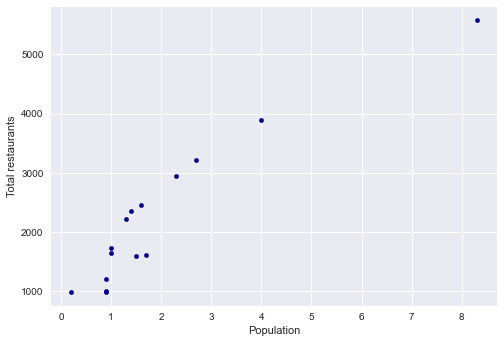

In [15]:
ax1 = df_cities.plot.scatter(x='Population',
                      y='Total restaurants',
                      c='DarkBlue')

This chart shows that the higher the population, the more restaurants there are in Foursquare. New York is twice as big as the following city in population, so we will take it out of the group of target cities.

In [16]:
df_cities.drop([9], axis = 0, inplace = True)
df_cities

,City,Total restaurants,State,Population
0,Austin,1642,Texas,1.0
1,Chicago,3207,Illinois,2.7
2,Columbus,981,Ohio,0.9
3,Columbus,981,Georgia,0.2
4,Dallas,2215,Texas,1.3
5,Fort Worth,1002,Texas,0.9
6,Houston,2952,Texas,2.3
7,Jacksonville,1208,Florida,0.9
8,Los Angeles,3888,California,4.0
10,Philadelphia,2458,Pennsylvania,1.6


We will also delete Columbus, Georgia, since the right one is in the state of Ohio

In [17]:
df_cities.drop([3], axis = 0, inplace = True)

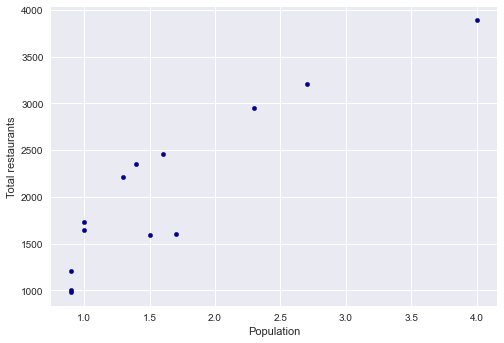

In [18]:
ax1 = df_cities.plot.scatter(x='Population',
                      y='Total restaurants',
                      c='DarkBlue')

We can see the data is quite consistent, since the larger the city, more restaurants we will find. 
Let's see if this trend is the same for the Italian restaurants

In [19]:
italian_restaurants = restaurants[restaurants['Cuisine']=='Italian']
italian_restaurants.rename(columns = {'Total restaurants':'Italian restaurants'}, inplace = True)
italian_restaurants

/Users/idejuan/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,City,Cuisine,Italian restaurants
36,New York City,Italian,334
100,Los Angeles,Italian,195
165,Chicago,Italian,214
228,Houston,Italian,164
293,Phoenix,Italian,130
357,Philadelphia,Italian,168
422,San Antonio,Italian,111
487,San Diego,Italian,153
552,Dallas,Italian,129
617,San Jose,Italian,56


In [20]:
df_cities = pd.merge(df_cities, italian_restaurants, on='City')
list(df_cities.columns)

['City',
 'Total restaurants',
 'State',
 'Population',
 'Cuisine',
 'Italian restaurants']

In [21]:
df_cities = df_cities[["City","Total restaurants","Italian restaurants","State","Population"]]
df_cities

,City,Total restaurants,Italian restaurants,State,Population
0,Austin,1642,128,Texas,1.0
1,Chicago,3207,214,Illinois,2.7
2,Columbus,981,94,Ohio,0.9
3,Dallas,2215,129,Texas,1.3
4,Fort Worth,1002,63,Texas,0.9
5,Houston,2952,164,Texas,2.3
6,Jacksonville,1208,107,Florida,0.9
7,Los Angeles,3888,195,California,4.0
8,Philadelphia,2458,168,Pennsylvania,1.6
9,Phoenix,1607,130,Arizona,1.7


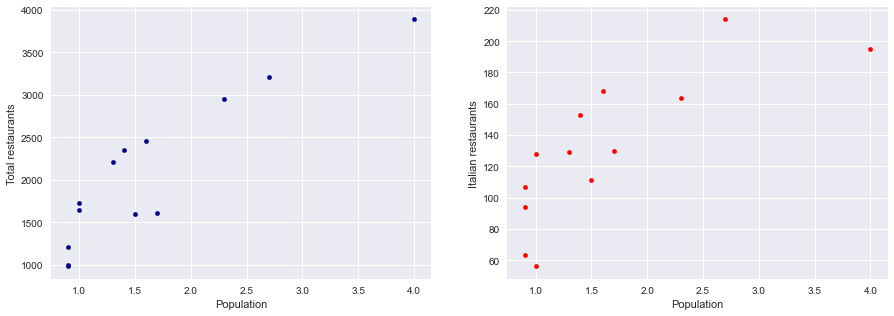

In [22]:
fig = plt.figure()

# Divide the figure into a 1x2 grid, and give me the first section
ax1 = fig.add_subplot(121)

# Divide the figure into a 1x2 grid, and give me the second section
ax2 = fig.add_subplot(122)


ax1 = df_cities.plot.scatter(x='Population',
                      y='Total restaurants',
                      c='DarkBlue',figsize = (15,5), ax = ax1)

ax2 = df_cities.plot.scatter(x='Population',
                      y='Italian restaurants',
                      c='Red',figsize = (15,5), ax = ax2)

Let's look at the percentage of population from Italian descent. 
Source: https://en.wikipedia.org/wiki/Italian_Americans#U.S._states_with_over_10%_people_of_Italian_ancestry

In [23]:
italian_origin = {'Alabama' : 1.7,
            'Alaska' : 3.3,
            'Arizona' : 4.4,
            'Arkansas' : 1.6,
            'California' : 4.0,
            'Colorado' : 5.1,
            'Connecticut' : 18.7,
            'Delaware': 9.9,
            'Florida' : 6.2,
            'Georgia' : 2.2,
            'Hawaii' : 2.1,
            'Idaho' : 3.2,
            'Illinois' : 6.2,
            'Indiana' : 2.7,
            'Iowa' : 2.1,
            'Kansas' : 2.3,
            'Kentucky' : 2.0,
            'Louisiana' : 4.8,
            'Maine' : 5.6,
            'Maryland' : 5.2,
            'Massachusetts' : 13.9,
            'Michigan' : 4.7,
            'Minnesota' : 2.3,
            'Mississippi' : 1.8,
            'Missouri' : 3.4,
            'Montana' : 3.5,
            'Nebraska' : 2.8,
            'Nevada' : 6.3,
            'New Hampshire' : 10.3,
            'New Jersey' : 16.8,
            'New Mexico' : 2.4,
            'New York' : 13.5,
            'North Carolina' : 3.0,
            'North Dakota' : 1.2,
            'Ohio' : 6.4,
            'Oklahoma' : 1.7,
            'Oregon' : 3.8,
            'Pennsylvania' : 12.2,
            'Rhode Island' : 18.9,
            'South Carolina' : 2.9,
            'South Dakota' : 1.4,
            'Tennessee' : 2.2,
            'Texas' : 1.9,
            'Utah' : 2.7,
            'Vermont' : 7.4,
            'Virginia' : 4.0,
            'Washington' : 3.6,
            'West Virginia' : 4.7,
            'Wisconsin' : 3.5,
            'Wyoming' : 3.1,
            'District of Columbia' : 3.3}


df_italian_origin = pd.DataFrame(list(italian_origin.items()),columns = ['State','Italian origin']) 
df_italian_origin.head()

,State,Italian origin
0,Alabama,1.7
1,Alaska,3.3
2,Arizona,4.4
3,Arkansas,1.6
4,California,4.0


In [24]:
df_cities = pd.merge(df_cities, df_italian_origin, on='State')
df_cities['italian_rest_perc'] = round(df_cities['Italian restaurants']/df_cities['Total restaurants'],2)
df_cities

,City,Total restaurants,Italian restaurants,State,Population,Italian origin,italian_rest_perc
0,Austin,1642,128,Texas,1.0,1.9,0.08
1,Dallas,2215,129,Texas,1.3,1.9,0.06
2,Fort Worth,1002,63,Texas,0.9,1.9,0.06
3,Houston,2952,164,Texas,2.3,1.9,0.06
4,San Antonio,1595,111,Texas,1.5,1.9,0.07
5,Chicago,3207,214,Illinois,2.7,6.2,0.07
6,Columbus,981,94,Ohio,0.9,6.4,0.10
7,Jacksonville,1208,107,Florida,0.9,6.2,0.09
8,Los Angeles,3888,195,California,4.0,4.0,0.05
9,San Diego,2348,153,California,1.4,4.0,0.07


In [25]:
df_cities['italian_rest_per_m_pop']=round(df_cities['Italian restaurants']/(df_cities['Population']/1000))
df_cities['total_rest_per_m_pop']=round(df_cities['Total restaurants']/(df_cities['Population']/1000))



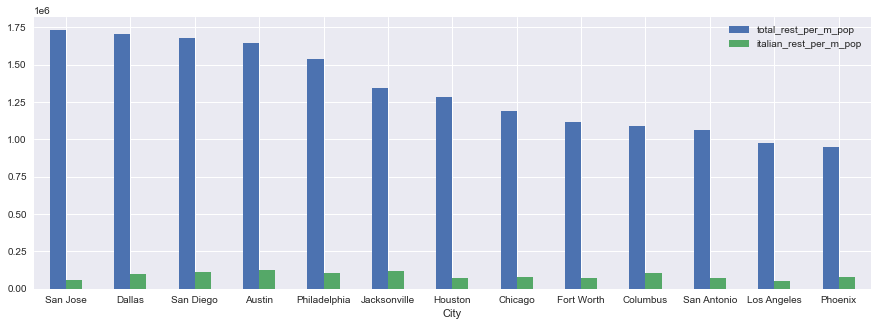

In [26]:
ax3 = df_cities.sort_values('total_rest_per_m_pop', ascending = False).plot.bar(x = 'City',y =['total_rest_per_m_pop','italian_rest_per_m_pop'],rot=0, figsize = (15,5), sort_columns = True)

This concludes the Data section of this project. In the next sections we will discuss and further analyse the datasets.

,City,italian_rest_perc,Italian origin,Population
0,Austin,0.08,1.9,1.0
1,Dallas,0.06,1.9,1.3
2,Fort Worth,0.06,1.9,0.9
3,Houston,0.06,1.9,2.3
4,San Antonio,0.07,1.9,1.5
5,Chicago,0.07,6.2,2.7
6,Columbus,0.10,6.4,0.9
7,Jacksonville,0.09,6.2,0.9
8,Los Angeles,0.05,4.0,4.0
9,San Diego,0.07,4.0,1.4


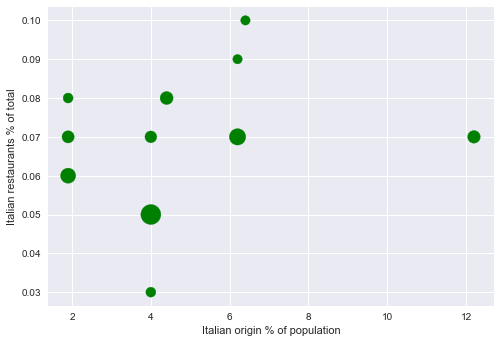

In [27]:
df_cities['bubble_size']=df_cities['Population']*100

ax4 = plt.scatter(x='Italian origin',
                      y='italian_rest_perc',s='bubble_size',
                      c='Green', data=df_cities)
plt.xlabel("Italian origin % of population")
plt.ylabel("Italian restaurants % of total")
df_cities[['City','italian_rest_perc','Italian origin','Population']]

The larger the city, there is more competition among different cuisines, so a good approach would be to look for opportunities in smaller cities that are lagging behind cities of similar size.

Following this approach, a good recommendation would be to look at San Jose, since comparing it to other cities in California, it has less percentage of Italian restaurants.

On the other hand, Philadelphia shows up as a city with potential. A large percentage of Italian origin population in the state could also build up on the same direction of investing in this city.

### Further research and caveats of this analysis

#### Caveats
- Foursquare data may be uneven in different cities even if we have chosen all cities in US  
- Ethnic origin of population is at state level, not city level
- The population in the Wikipedia table may refer to a different geography than the geography applied by Foursquare in the queries

#### Further research
- Look at the evolution in time  
- Analyse the preferences of the consumers also in terms of assessment of the existing restaurants  
- Differentiate different level of budget in the restaurants  
- Look at composition of the population and income in the city
- Zoom into the cities that have been selected to better understand the competition, both in geographical terms as well as other types of cuisines
- Polinomial regression analysis: number or IT rest (y), number of rest, pop size, italian origin, average punctuation feedback

In [28]:
# Group the assessment and group